# Assignment 2

In this assignment, you will be working on an image classification task (codename `pnp`) using the transfer learning technique.
The task objective is to determine whether an image contains a person (`pnp` stands for person / non-person) -- a binary classification task.

## Dataset
* Dataset contains 80K images with known labels (for model development), and 20K images with unknown labels (for scoring).
* Dataset has been created from a subset of COCO Dataset, and so all copyrights belong to the original authors: https://cocodataset.org/#termsofuse
* Images have been rescaled and padded to be of shape (224, 224, 3).

While it's possible to create a new model architecture and train a model specifically for this task, that would be expensive in terms of time and cloud resources.
Instead, in this assignment, you will be re-using an pre-trained model's architecture and parameters to save time and cloud resources.

## MobileNet Architecture
* The pre-trained model's name is MobileNetV2: https://arxiv.org/pdf/1801.04381.pdf
* MobileNet is a relatively small network that is designed for usage on mobile devices with limited compute and storage resource.
* It's a great choice for this assignment, since this network can be relatively quickly processed with a single GPU.

## MobileNet Parameters
* Keras provides network architecture and pre-trained parameters: https://keras.io/api/applications/mobilenet/#mobilenetv2-function
* The pre-trained parameters come from the ImageNet 1000-class task, which does not include a person label.
* The lower part of the network can be reused due to the shared hierarchy of visual information..


In [10]:
!ls pnp_dataset.zip || (wget https://danylo-ucla.s3.us-west-2.amazonaws.com/pnp_dataset.zip)

pnp_dataset.zip


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import PIL.Image


def load_images(folder: str) -> np.ndarray:
    images = []
    with zipfile.ZipFile('pnp_dataset.zip') as z:
        targets = sorted(p for p in z.namelist() if p.startswith(folder))
        for target in targets:
            with z.open(target) as f:
                images.append(np.array(PIL.Image.open(f)))
            
    return np.array(images)

In [13]:
train_x = load_images('pnp_dataset/train_x')
score_x = load_images('pnp_dataset/score_x')
with zipfile.ZipFile('pnp_dataset.zip') as z:
    with z.open('pnp_dataset/train_y.npy') as f:
        train_y = np.load(f)

In [14]:
train_x.shape, train_y.shape

((80000, 224, 224, 3), (80000,))

In [15]:
train_y[:5]

array([1, 0, 1, 1, 1])

1

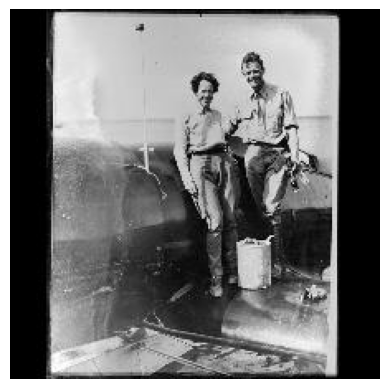

In [16]:
plt.imshow(train_x[0])
plt.axis('off')
train_y[0]

0

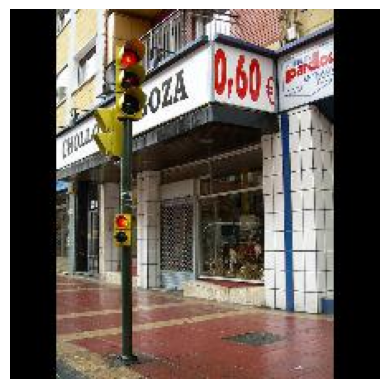

In [17]:
plt.imshow(train_x[1])
plt.axis('off')
train_y[1]

In [18]:
# This configures the GPU to be used by Tensorflow.

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2023-07-02 20:19:15.234042: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 20:19:15.234262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 20:19:15.259309: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 20:19:15.259554: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 20:19:15.259730: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [19]:
# https://arxiv.org/pdf/1801.04381.pdf
# https://keras.io/api/applications/mobilenet/#mobilenetv2-function
mobile_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(224, 224, 3),
    weights="imagenet"
)

2023-07-02 20:19:15.271432: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-02 20:19:15.417298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 20:19:15.417491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-02 20:19:15.417659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [20]:
# Freezes the parameters of the MobileNet layers, so they will not update during training.
# These parameters are initialized to a pre-trained snapshot using the ImagetNet dataset.
mobile_net.trainable = False

In [21]:
# mobile_net.summary()

In [22]:
model = tf.keras.models.Sequential([
    mobile_net,
    tf.keras.layers.AvgPool2D(pool_size=(5, 5)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1)
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 1280)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
model.compile(
    optimizer='sgd',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(
            name="binary_accuracy",
            threshold=0.5
        )
    ]
)
batch_size = 128

In [25]:
with tf.device('/CPU:0'):
    train_x = tf.constant(train_x)
    train_y = tf.constant(train_y)
    score_x = tf.constant(score_x)

2023-07-02 20:19:16.482374: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12042240000 exceeds 10% of free system memory.
2023-07-02 20:19:19.971325: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3010560000 exceeds 10% of free system memory.


In [26]:
model.fit(
    train_x,
    train_y,
    epochs=1,
    batch_size=batch_size
)

2023-07-02 20:19:22.081446: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8800
2023-07-02 20:19:22.526406: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 20:19:22.527181: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 20:19:22.527192: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-07-02 20:19:22.527688: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-02 20:19:22.527729: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


625/625 [==============================] - 25s 35ms/step - loss: 7.5654 - binary_accuracy: 0.5021


In [27]:
import os 
import pandas as pd

model_dir = 'pnp_model'

os.makedirs(model_dir, exist_ok=True)

# Once you are ready to make the graded submission,
# run the model on the score dataset.
score_y_hat = pd.DataFrame(
    model.predict(score_x, batch_size=batch_size),
    # This is needed to save the file in Parquet format.
    columns=['score']
)

# Now save it to disc as a Parquet file.
score_y_hat.to_parquet(f'{model_dir}/score_y_hat.parquet')

# Next, let's save the model's definition.
import json
with open(f'{model_dir}/keras_model.json', 'w') as f:
    f.write(json.dumps(json.loads(model.to_json()), indent=True))

# Finally, let's save the learned parameters.
model.save_weights(f'{model_dir}/keras_parameters.h5')

# You now have the following files to be uploaded to Moodle:
# 1. This notebook and any other Python code you used to train the final model.
# 2. keras_model.json -- the model's definition
# 3. keras_parameters.json -- the model's trained parameters
# 4. score_y_hat.parquet - the model's output on the score dataset